In [ ]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu11==24.6.0
!pip install --extra-index-url=https://pypi.nvidia.com dask-cudf-cu12==24.6.0

In [ ]:
import pandas as pd
import cudf
import dask
import dask.dataframe as dd
dask.config.set(DASK_DATAFRAME__BACKEND=cudf)
# dask.config.set({"dataframe.backend": "cudf"})
pqdf = dd.read_parquet('/content/drive/MyDrive/datasharing-dir/francetax.parquet')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/datasharing-dir'
os.chdir(folder_path)

Mounted at /content/drive


Best hyperparameters RFR: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}




In [ ]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/datasharing-dir/selected_features.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
# print(df.columns)
import warnings
warnings.filterwarnings('ignore')
df = df[['Total_Tax_Revenue',
         'CFE - CHAMBRE DES METIERS / DROIT FIXE / MONTANT',
         "FNB - CHAMBRE D'AGRICULTURE / MONTANT REEL",
         'IFER STATIONS RADIOELECTRIQUES ART 1519 H DU CGI / COMMUNE / MONTANT',
         "TF - DEGREVEMENT D'OFFICE  /  COTISATIONS < 12 EUROS - MONTANT",
         'TH - COTISATIONS < 12 EUROS (TOTAL DONT REFORME TH) - MONTANT',
         'TH - DEGREVEMENTS GESTIONNAIRES DE FOYERS - MONTANT',
         'TH - NON-VALEURS HORS REFORME TH - MONTANT']]
# Select the relevant columns
# df = df.sample(n=50000, random_state=42)
X = df.drop(columns=['Total_Tax_Revenue'])
y = df['Total_Tax_Revenue']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the Random Forest model
rf = RandomForestRegressor()

# Create the RFE object
rfe = RFE(rf)

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Regressor with the best parameters
best_rfr = RandomForestRegressor(
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_rfr, X, y, cv=5, scoring='r2')

# Print the results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean R2 score: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of R2 score: {np.std(cv_scores):.4f}")

# Train the final model on the entire dataset
best_rfr.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rfr.predict(X_test)

# Calculate the R-squared score on the test set
r2 = r2_score(y_test, y_pred)
print(f"R-squared score on test set: {r2:.4f}")



Cross-validation scores: [0.6611748  0.54391837 0.87726948 0.85784876 0.77044687]
Mean R2 score: 0.7421
Standard deviation of R2 score: 0.1251
R-squared score on test set: 0.8742


In [ ]:
# Print feature importances
feature_importance = best_rfr.feature_importances_
for feature, importance in zip(X_train.columns, feature_importance):
    print(f"{feature}: {importance:.4f}")

CFE - CHAMBRE DES METIERS / DROIT FIXE / MONTANT: 0.5014
FNB - CHAMBRE D'AGRICULTURE / MONTANT REEL: 0.4211
IFER STATIONS RADIOELECTRIQUES ART 1519 H DU CGI / COMMUNE / MONTANT: 0.0404
TF - DEGREVEMENT D'OFFICE  /  COTISATIONS < 12 EUROS - MONTANT: 0.0108
TH - COTISATIONS < 12 EUROS (TOTAL DONT REFORME TH) - MONTANT: 0.0002
TH - DEGREVEMENTS GESTIONNAIRES DE FOYERS - MONTANT: 0.0247
TH - NON-VALEURS HORS REFORME TH - MONTANT: 0.0013


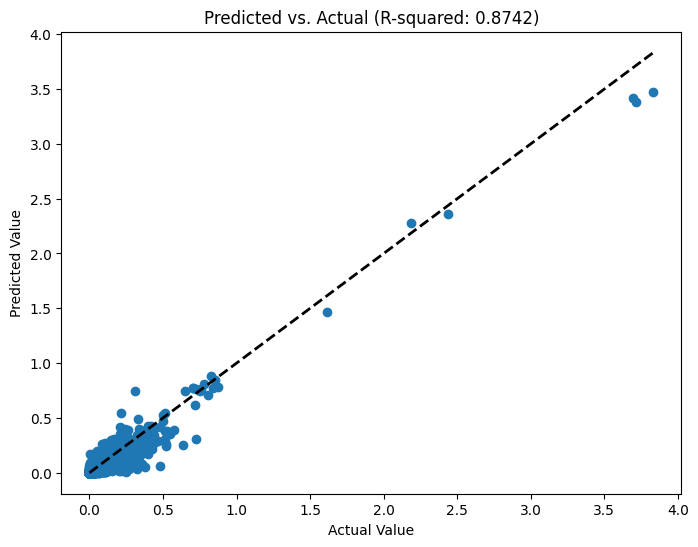

In [ ]:

# Plot the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title(f'Predicted vs. Actual (R-squared: {r2:.4f})')
plt.show()
